In [1]:
# Importerer pakker:
from diabetesmodel import MVPmodel
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

# Lidt om implementationen

Modellerne er implementeret via. en class, "MVPmodel", som er defineret i diabetesmodel.py filen.

Objekter tilhørende denne class har nogle forskellige egenskaber. Default-værdier til egenskaberne kan ses og sættes i "config.json" filen. 
Vi ved ikke om disse værdier giver mening endnu!!

Defaults kan overrides via. keyword arguments når man laver objektet.

In [2]:
patient1 = MVPmodel() # Objekt med default værdier.
patient2 = MVPmodel(G = 120) # Objekt hvor G initialiseres til at være 120.
print("De forskellige egenskaber og tilhørerende default værdier:")
pprint(patient1.__dict__)

De forskellige egenskaber og tilhørerende default værdier:
{'C1': 20.1,
 'D1': 0,
 'D2': 0,
 'G': 108,
 'Gbar': 108,
 'Gmin': 70,
 'Gsc': 108,
 'Ieff': 0.01,
 'Ip': 1.25,
 'Isc': 1.25,
 'Kp': 0.25,
 'S1': 0.0081,
 'Td': 15,
 'Ti': 500,
 'Vg': 253,
 'egp0': 1.33,
 'gezi': 0.0022,
 'kappa': 10000000.0,
 'p2': 0.0106,
 'tau1': 49,
 'tau2': 47,
 'taum': 47,
 'tausc': 5,
 'us': 25,
 'x': [0, 0, 1.25, 1.25, 0.01, 108, 108],
 'x0': [0, 0, 1.25, 1.25, 0.01, 108, 108]}


Egenskabernes værdier kan også sættes efterfølgende. Dog skal man være opmærksom på at deres "start state", x0, bliver defineret ved initialisation. 

In [3]:
print(f"Objekts 'G' værdi ved initialisation: {patient1.G}")
patient1.G = 130
print(f"Ændres til: {patient1.G}")
patient1.reset()
print(f"Efter reset: {patient1.G}")

Objekts 'G' værdi ved initialisation: 108
Ændres til: 130
Efter reset: 108


# Simulationer med given insulin injection rate

Man kan simulere en patients state ud fra deres insulin injection rate og deres kulhydratsindtag med "iterate" methoden (navngivning er nok lidt et work in progress)

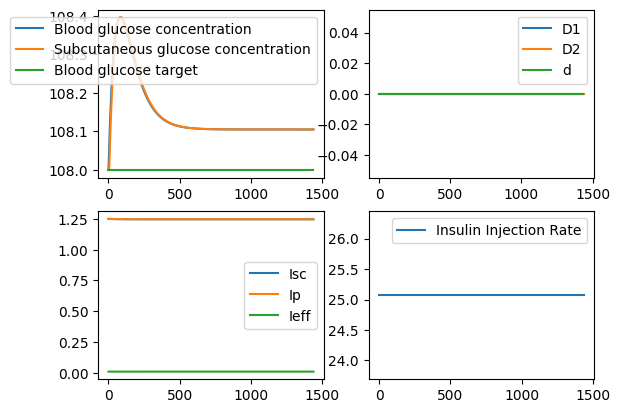

In [4]:
patient1.reset()
n = (24 * 60)//patient1.tausc # Antal timesteps for at have en 24 timers simulation. Parameteren "tausc" er længden af et timestep i minutter. 
u_list = 25.07 * np.ones(n) # Insulin injection rate array, på 25.07 mU/min under hele simulationen.
d_list = np.zeros(n) # De får ingen kulhydrater hele dagen :(
states = patient1.iterate(u_list, d_list) # Kører simulationen. Returnerer en matrice som indeholder patientens state under simulationen. 
patient1.plot(states, u_list, d_list) # Dette er bare et shortcut til at plotte. Det er måske ikke lige det smukkeste plot lige nu.

# Simulationer med insulin injection kontrolleret af controller

Man kan køre simulationer hvor insulin injection raten bestemmes af PID-controlleren, via. simulate methoden.

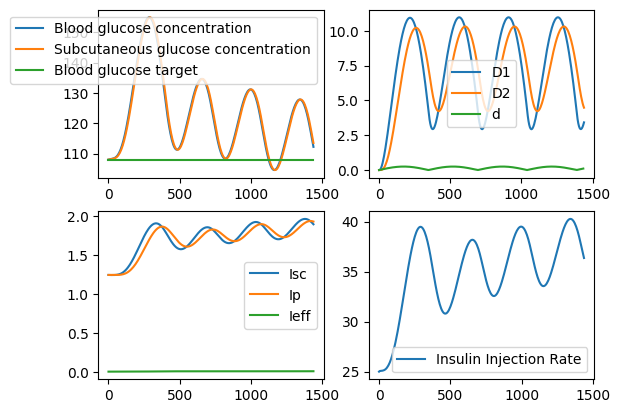

In [5]:
patient1.reset()
d = np.abs(np.sin(np.linspace(0,13,n))) / 4 # Lidt funky spisemønster.
states, u = patient1.simulate(d)
patient1.plot(states, u, d)

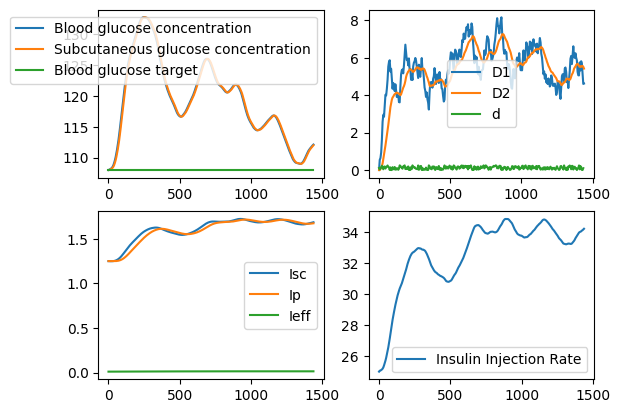

In [6]:
patient1.reset()
d = np.random.rand(n) / 4 # Med høj sandsynlighed, et endnu mere funky spisemønster.
states, u = patient1.simulate(d)
patient1.plot(states, u, d)

# Bolus beregninger

Givet en insulin bolus størrelse (målt i "U") og gram kulhydrater, simulerer "bolus_sim" patientens state, og returnerer "arealet under penalty kurven", penalty funktionens værdi i hvert tidsstep, og blood glucose i hvert tidsstep. 

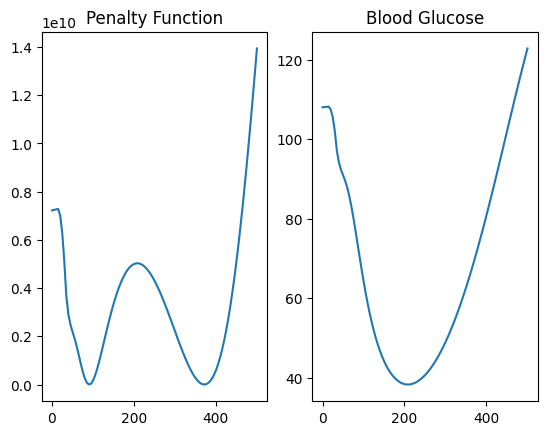

In [7]:
patient1.reset()
phi, p, Gt = patient1.bolus_sim(30, 75, 5, plot=True) # Bolus på 30 U, og måltid på 75 g kulhydrater.

Man kan iterere igennem disse simulationer med "optimal_bolus", som genererer et (meget kedeligt at kigge på) heatplot, hvor hver pixels farve indikerer "penalty-integralets" værdi for den givne kombination af bolus og måltidsstørrelse. De laveste værdier for hver meal size er markeret med rød.

Funktionen returnerer løsningen til least squares problemet: $\text{"optimal bolus"} = a \cdot \text{"meal size"} + b$

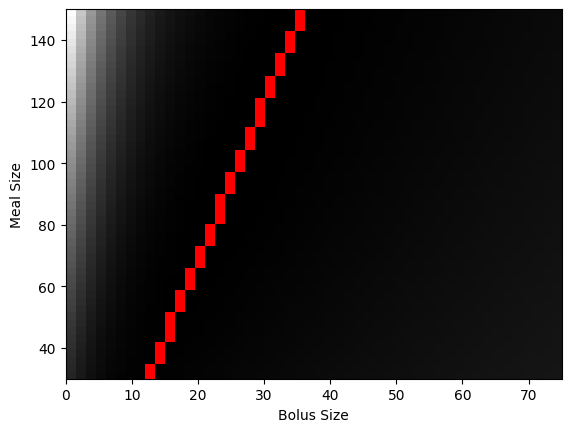

In [8]:
patient1.reset()
a, b = patient1.optimal_bolus(meal_idx = 5)

Man kan bruge disse værdier til nemt at opsætte en funktion til at bestemme den optimale bolus størrelse, givet en måltidsstørrelse:

In [9]:
bolus_for_meal = lambda meal : a * meal + b
print(a, b)
bolus_for_meal(75)

-0.19387755102040818 41.326530612244895


26.78571428571428